Mounted at /content/drive
Data loaded successfully from /content/drive/My Drive/training1.csv. Shape: (400, 3458)
Data loaded successfully from /content/drive/My Drive/training2.csv. Shape: (2750, 3458)
Data loaded successfully from /content/drive/MyDrive/test.csv. Shape: (1000, 3456)
Fold 1 - Validation Accuracy: 0.6761904954910278
Fold 2 - Validation Accuracy: 0.6555555462837219
Fold 3 - Validation Accuracy: 0.6539682745933533
Fold 4 - Validation Accuracy: 0.658730149269104
Fold 5 - Validation Accuracy: 0.6317460536956787

Cross-validation results:
Fold 1: 0.6761904954910278
Fold 2: 0.6555555462837219
Fold 3: 0.6539682745933533
Fold 4: 0.658730149269104
Fold 5: 0.6317460536956787


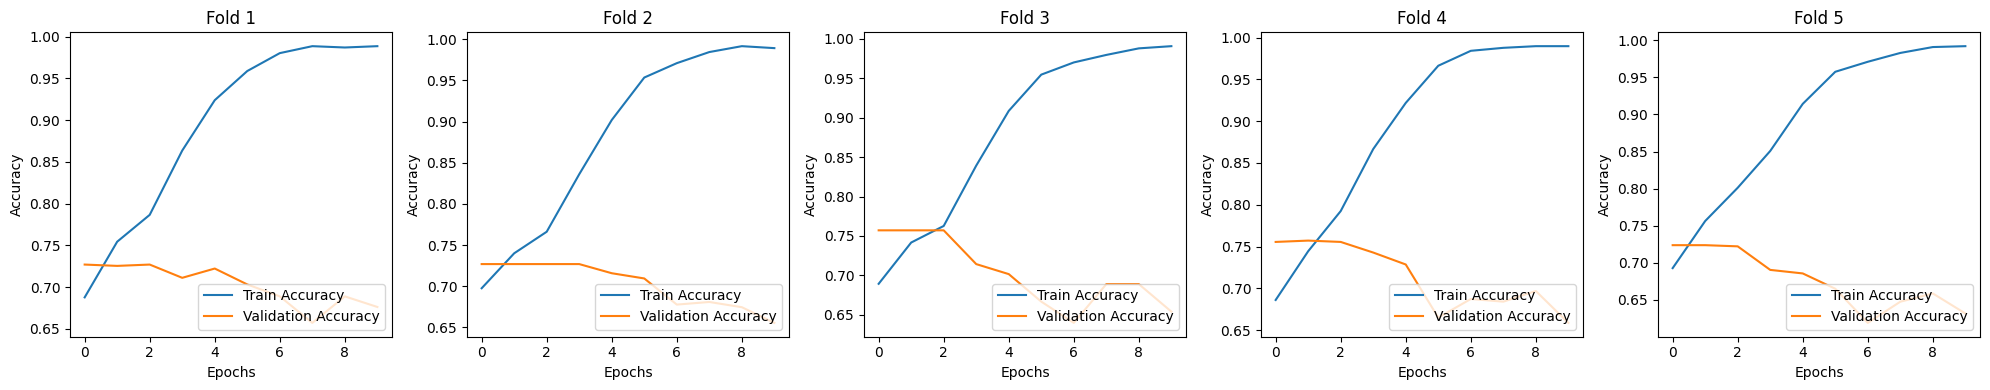

Average Validation Accuracy: 0.6552381038665771
Epoch 1/10
99/99 [==============================] - 3s 9ms/step - loss: 0.6760 - accuracy: 0.7086
Epoch 2/10
99/99 [==============================] - 1s 7ms/step - loss: 0.5653 - accuracy: 0.7365
Epoch 3/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5085 - accuracy: 0.7578
Epoch 4/10
99/99 [==============================] - 1s 7ms/step - loss: 0.4050 - accuracy: 0.8165
Epoch 5/10
99/99 [==============================] - 1s 7ms/step - loss: 0.2897 - accuracy: 0.8829
Epoch 6/10
99/99 [==============================] - 1s 7ms/step - loss: 0.2048 - accuracy: 0.9263
Epoch 7/10
99/99 [==============================] - 1s 6ms/step - loss: 0.1227 - accuracy: 0.9568
Epoch 8/10
99/99 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.9676
Epoch 9/10
99/99 [==============================] - 0s 5ms/step - loss: 0.0665 - accuracy: 0.9816
Epoch 10/10
32/32 [==============================] - 0s 5ms/step
Predi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from google.colab import drive

# Mount Google Drive to access files stored there
drive.mount('/content/drive')

def load_data(file_path):
    """Load data from a specified CSV file path."""
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}. Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

def preprocess_data(data):
    """Preprocess the data by imputing, scaling, and applying PCA."""
    if data is None:
        print("No data provided for preprocessing.")
        return None, None

    # Impute missing values, scale features, and apply PCA
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    pca = PCA(n_components=961)  # Perfect square for reshaping in CNN (31x31)

    features = data.iloc[:, :-1]
    labels = data.iloc[:, -1]

    features = imputer.fit_transform(features)
    features = scaler.fit_transform(features)
    features = pca.fit_transform(features)

    labels = labels.fillna(0).astype(int)  # Handle missing labels

    return features, labels

def create_model(input_shape):
    """Create a Keras sequential model for binary classification."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def main():
    """Main function to execute model training and evaluation."""
    # Paths to the data files on Google Drive
    train1_path = '/content/drive/My Drive/training1.csv' # Change to path file
    train2_path = '/content/drive/My Drive/training2.csv' # Change to path file
    test_path = '/content/drive/MyDrive/test.csv' # Change to path file

    # Load and merge training datasets
    train1 = load_data(train1_path)
    train2 = load_data(train2_path)
    test = load_data(test_path)

    if train1 is not None and train2 is not None:
        train = pd.concat([train1, train2], ignore_index=True)
    else:
        print("Error: Training data could not be loaded.")
        return

    # Preprocess training and test data
    X_train, y_train = preprocess_data(train)
    X_test, _ = preprocess_data(test)

    feature_root = int(np.sqrt(X_train.shape[1]))  # Reshape dimensions (31x31)
    X_train = X_train.reshape(-1, feature_root, feature_root, 1)
    X_test = X_test.reshape(-1, feature_root, feature_root, 1)

    # Perform cross-validation
    # Define variables to store training results
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1
    cv_results = []
    history_list = []  # Initialize the list here to store history objects for each fold

    for train_idx, val_idx in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = create_model((feature_root, feature_root, 1))
        history = model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32,
                            validation_data=(X_fold_val, y_fold_val), verbose=0)

        history_list.append(history)  # Append the training history after each fold

        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")
        cv_results.append(val_accuracy)
        fold_no += 1

    print("\nCross-validation results:")
    for i, val_acc in enumerate(cv_results, 1):
        print(f"Fold {i}: {val_acc}")

    # Plot training and validation accuracy for each fold
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    for idx, history in enumerate(history_list):
        ax = axes[idx]
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_title(f'Fold {idx + 1}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    print(f"Average Validation Accuracy: {np.mean(cv_results)}")

    # Train the final model and save predictions
    model = create_model((feature_root, feature_root, 1))
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int).flatten()  # Binary classification

    # Save predictions in the required format
    predictions_df = pd.DataFrame(predictions, columns=['prediction'])
    predictions_df.to_csv("/content/drive/My Drive/predictions.csv", index=False)
    print("Predictions saved to predictions.csv.")

if __name__ == "__main__":
    main()
